# [PUBLIC] Analysis of CLBlast client multiple sizes

<a id="overview"></a>
## Overview

This Jupyter Notebook analyses the performance that CLBlast  (single configuaration) achieves across a range of sizes.

<a id="data"></a>
## Get the experimental data from DropBox

**NB:** Please ignore this section if you are not interested in re-running or modifying this notebook. 

The experimental data was collected on the experimental platform and archived as follows:
```
$ cd `ck find ck-math:script:<...>`
$ python <...>.py
$ ck zip local:experiment:* --archive_name=<...>.zip
```

It can be downloaded and extracted as follows:
```
$ wget <...>.zip
$ ck add repo:<....> --zip=<....>.zip --quiet
```

<a id="code"></a>
## Data wrangling code

**NB:** Please ignore this section if you are not interested in re-running or modifying this notebook.

### Includes

#### Standard

In [34]:
import os
import sys
import json
import re

#### Scientific

If some of the scientific packages are missing, please install them using:
```
# pip install jupyter pandas numpy matplotlib
```

In [35]:
import IPython as ip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mp

In [36]:
print ('IPython version: %s' % ip.__version__)
print ('Pandas version: %s' % pd.__version__)
print ('NumPy version: %s' % np.__version__)
print ('Seaborn version: %s' % sns.__version__) # apt install python-tk
print ('Matplotlib version: %s' % mp.__version__)

IPython version: 5.3.0
Pandas version: 0.19.2
NumPy version: 1.12.0
Seaborn version: 0.7.1
Matplotlib version: 2.0.0


In [37]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [38]:
from IPython.display import Image
from IPython.core.display import HTML

#### Collective Knowledge

If CK is not installed, please install it using:
```
# pip install ck
```

In [39]:
import ck.kernel as ck
print ('CK version: %s' % ck.__version__)

CK version: 1.8.7


### Define helper functions

In [40]:
# Return the number of floating-point operations for C = alpha * A * B + beta * C,
# where A is a MxK matrix and B is a KxN matrix.
def xgemm_flops(alpha, beta, M, K, N):
    flops_AB = 2*M*N*K if alpha!=0 else 0
    flops_C = 2*M*N if beta!=0 else 0
    flops = flops_AB + flops_C
    return flops

In [41]:
# Return GFLOPS (Giga floating-point operations per second) for a known kernel and -1 otherwise.
def GFLOPS(kernel, run_characteristics, time_ms):
    if kernel.lower().find('xgemm') != -1:
        time_ms = np.float64(time_ms)
        alpha = np.float64(run_characteristics['arg_alpha'])
        beta  = np.float64(run_characteristics['arg_beta'])
        M = np.int64(run_characteristics['arg_m'])
        K = np.int64(run_characteristics['arg_k'])
        N = np.int64(run_characteristics['arg_n'])
        return (1e-9 * xgemm_flops(alpha, beta, M, K, N)) / (1e-3 * time_ms)
    else:
        return (-1.0)

In [42]:
def convert2int(s):
    if s[-1]=='K':
        return np.int64(s[0:-1])*1024
    else:
        return np.int64(s)

In [43]:
def args_str(kernel, run):
    args = ''
    if kernel.lower().find('xgemm') != -1:
        args = 'alpha=%s, beta=%s, M=%s, K=%s, N=%s' % \
            (run['arg_alpha'], run['arg_beta'], run['arg_m'], run['arg_k'], run['arg_n'])
    return args

### Access the experimental data

In [44]:
def get_experimental_results(repo_uoa='local', tags='explore-clblast-matrix-size'):
    module_uoa = 'experiment'
    r = ck.access({'action':'search', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'tags':tags})
    if r['return']>0:
        print ("Error: %s" % r['error'])
        exit(1)
    experiments = r['lst']
    
    dfs = []
    for experiment in experiments:
        data_uoa = experiment['data_uoa']
        r = ck.access({'action':'list_points', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'data_uoa':data_uoa})
        if r['return']>0:
            print ("Error: %s" % r['error'])
            exit(1)

        for point in r['points']:
            with open(os.path.join(r['path'], 'ckp-%s.0001.json' % point)) as point_file:
                point_data_raw = json.load(point_file)
                characteristics_list = point_data_raw['characteristics_list']
                num_repetitions = len(characteristics_list)
                # Obtain column data.
                data = [
                    {
                        'repetition_id': repetition_id,
                        'm': convert2int(characteristics['run']['m'][0]),
                        'n': convert2int(characteristics['run']['n'][0]),
                        'k': convert2int(characteristics['run']['k'][0]),
                        #'mnk': convert2int(characteristics['run']['m'][0]) * convert2int(characteristics['run']['n'][0]) * convert2int(characteristics['run']['k'][0]),
                        'G': np.float32(characteristics['run']['GFLOPS_1'][0])
                        #'strategy'  : tuner_output['strategy'],
                        #'config_id': config_id,
                        #'config' : config['parameters'],
                        #'kernel' : config['kernel']
                        #'args_id' : args_str(config['kernel'], characteristics['run']),
                        #'ms' : np.float64(config['time']),
                        #'GFLOPS' : GFLOPS(config['kernel'], characteristics['run'], config['time'])
                    }
                    for (repetition_id, characteristics) in zip(range(num_repetitions), characteristics_list) 
                    #for (m,n,k,G,) in characteristics['run']
                    #for (config_id, config) in zip(range(len(tuner_output['result'])), tuner_output['result'])
                ]
            #print data    
             #Construct a DataFrame.
            df = pd.DataFrame(data)
            # Set columns and index names.
            df.columns.name = 'characteristics'
            df.index.name = 'index'
            df = df.set_index(['m', 'n', 'k', 'repetition_id'])
            # Append to the list of similarly constructed DataFrames.
            dfs.append(df)
    # Concatenate all constructed DataFrames (i.e. stack on top of each other).
    result = pd.concat(dfs)
    return result.sortlevel(result.index.names)


In [45]:
df = get_experimental_results(tags='explore-clblast-matrix-size-client')
pd.options.display.max_columns = len(df.columns)
pd.options.display.max_rows = len(df.index)

df

characteristics                       G
m    n    k    repetition_id           
128  128  1024 0              44.000000
               1              44.000000
               2              44.000000
256  512  256  0              67.000000
               1              66.599998
               2              67.000000
512  256  128  0              53.000000
               1              52.900002
               2              53.000000
1024 1024 128  0              64.800003
               1              64.800003
               2              64.800003

In [46]:
df = df.sortlevel(df.index.names[3])
#df.sort_value(level=df.index.names[3])
#df = df.sort_values('mnk')

In [47]:
#pd.options.display.max_columns=2
#df = df.reset_index('mnk').sort_values('mnk')

In [48]:
df_mean = df.groupby(level=df.index.names[:-1]).mean()
df_std = df.groupby(level=df.index.names[:-1]).std()


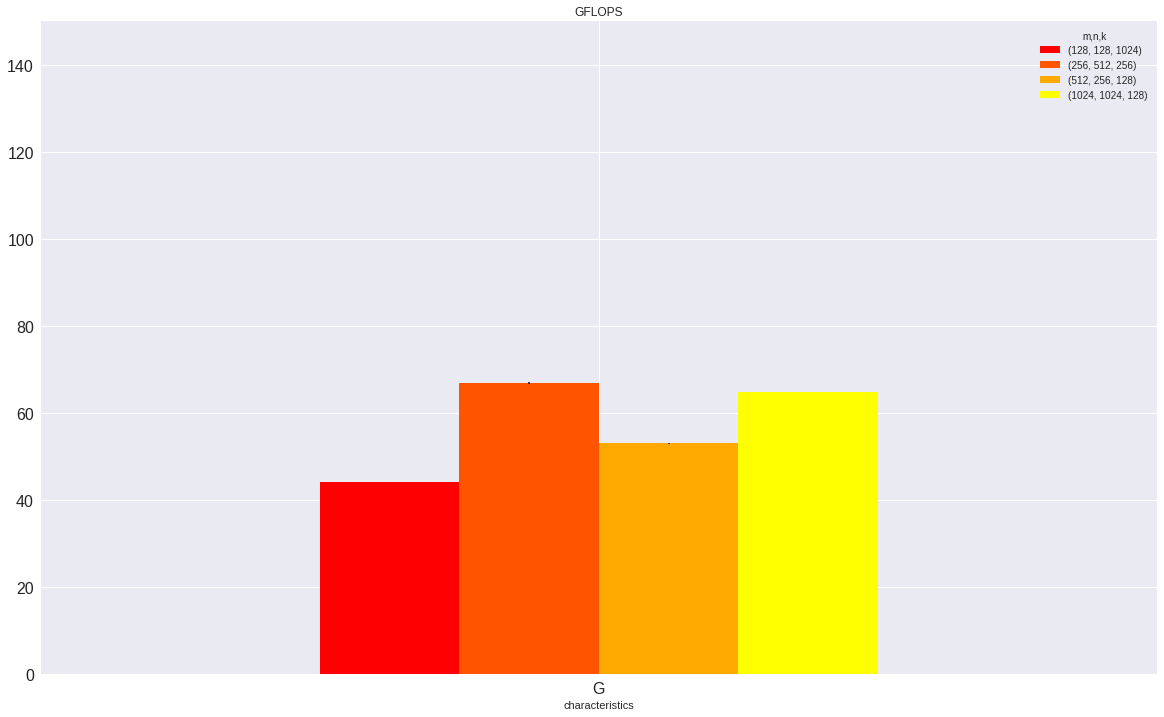

In [49]:
df_mean.T \
    .plot(yerr=df_std.T, title='GFLOPS',
          kind='bar', rot=0, ylim=[0,150], figsize=[20, 12], grid=True, legend=True, colormap=cm.autumn, fontsize=16)

In [50]:
kernel = df.iloc[0].name[0]
kernel

128